In [129]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from mobius import ForceField, VirtualTarget

In [11]:
data = []

with open('binding_data_2013/bdata.20130222.mhci.txt') as f:
    lines = f.readlines()
    
    for line in lines[1:]:
        sline = line.split()
        data.append((sline[0], sline[1], int(sline[2]), sline[3], sline[4], float(sline[5])))

columns = ['species', 'mhc_allele', 'length', 'sequence', 'inequality', 'affinity_binding']
mhci = pd.DataFrame(data=data, columns=columns)
mhci.to_csv('binding_data_2013/bdata.20130222.mhci.csv', index=False)

In [17]:
for name, group in mhci[mhci['species'] == 'human'].groupby('mhc_allele'):
    print(name, len(group))

HLA-A*01:01 4792
HLA-A*02:01 12160
HLA-A*02:02 4155
HLA-A*02:03 6303
HLA-A*02:04 4
HLA-A*02:05 75
HLA-A*02:06 5628
HLA-A*02:07 80
HLA-A*02:10 18
HLA-A*02:11 1085
HLA-A*02:12 1183
HLA-A*02:16 921
HLA-A*02:17 346
HLA-A*02:19 1246
HLA-A*02:50 135
HLA-A*03:01 7358
HLA-A*03:02 26
HLA-A*03:19 30
HLA-A*11:01 6399
HLA-A*11:02 14
HLA-A*23:01 2641
HLA-A*24:02 3280
HLA-A*24:03 1381
HLA-A*25:01 960
HLA-A*26:01 4535
HLA-A*26:02 643
HLA-A*26:03 537
HLA-A*29:02 2789
HLA-A*30:01 2925
HLA-A*30:02 2057
HLA-A*31:01 5713
HLA-A*32:01 1136
HLA-A*32:07 88
HLA-A*32:15 74
HLA-A*33:01 3597
HLA-A*66:01 219
HLA-A*68:01 3795
HLA-A*68:02 5545
HLA-A*68:23 82
HLA-A*69:01 2565
HLA-A*74:01 15
HLA-A*80:01 1171
HLA-A1 1
HLA-A11 74
HLA-A2 63
HLA-A24 2
HLA-A26 4
HLA-A3 6
HLA-A3/11 2
HLA-B*07:02 4642
HLA-B*08:01 3538
HLA-B*08:02 1020
HLA-B*08:03 470
HLA-B*14:01 42
HLA-B*14:02 341
HLA-B*15:01 4448
HLA-B*15:02 164
HLA-B*15:03 701
HLA-B*15:09 832
HLA-B*15:17 1447
HLA-B*15:42 364
HLA-B*18:01 2832
HLA-B*27:01 4
HLA-B*27:02 8
HLA

# HLA-A*02:01

(7.0, 15.0)

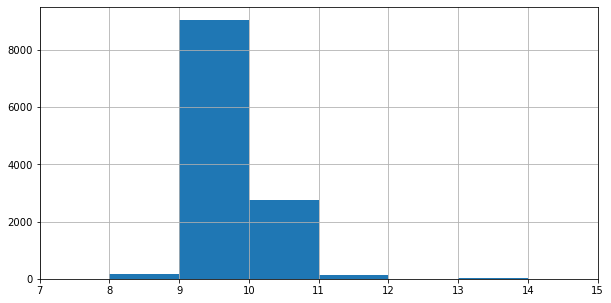

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['length'].hist(ax=ax, bins=range(7, 15))
ax.set_xlim([7, 15])

<AxesSubplot:>

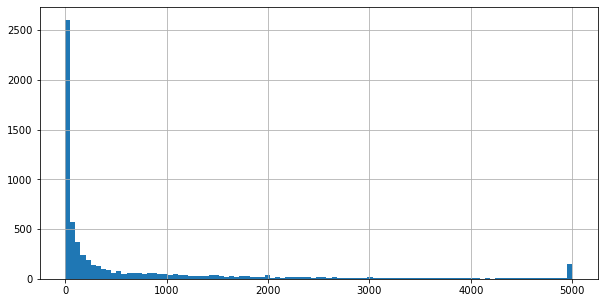

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['affinity_binding'].hist(ax=ax, bins=np.linspace(0, 5000, 100))

In [237]:
selected = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
                (mhci['length'] == 9) &
                (~selected['affinity_binding'].isin([20000, 69444.44444, 78125])) &
                (selected['affinity_binding'] < 5000)]
X_train, X_test, y_train, y_test = train_test_split(selected['sequence'], selected['affinity_binding'], test_size=0.33, random_state=42)

In [238]:
def transform_sequences(sequences):
    ff = ForceField()
    p = ff.parameters()
    
    transformed_sequences = []
    
    for seq in sequences:
        tmp = []
        for aa in seq:
            h, v = p[p['AA1'] == aa][['hydrophilicity', 'volume']].tolist()[0]
            tmp.extend([float(1 - h), float(v)])
        
        transformed_sequences.append(tmp)
        
    return np.array(transformed_sequences)

In [239]:
X_train_transformed = torch.from_numpy(transform_sequences(X_train)).float()
X_test_transformed = torch.from_numpy(transform_sequences(X_test)).float()

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

In [240]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [241]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_transformed, y_train, likelihood)

In [242]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

In [243]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train_transformed)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 453303.125   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 408801.281   lengthscale: 0.644   noise: 0.744
Iter 3/50 - Loss: 369639.438   lengthscale: 0.598   noise: 0.798
Iter 4/50 - Loss: 335971.250   lengthscale: 0.555   noise: 0.853
Iter 5/50 - Loss: 307840.094   lengthscale: 0.515   noise: 0.909
Iter 6/50 - Loss: 285028.031   lengthscale: 0.479   noise: 0.966
Iter 7/50 - Loss: 266926.688   lengthscale: 0.447   noise: 1.023
Iter 8/50 - Loss: 252513.375   lengthscale: 0.420   noise: 1.081
Iter 9/50 - Loss: 240559.766   lengthscale: 0.399   noise: 1.139
Iter 10/50 - Loss: 229990.156   lengthscale: 0.384   noise: 1.196
Iter 11/50 - Loss: 220119.047   lengthscale: 0.373   noise: 1.252
Iter 12/50 - Loss: 210636.469   lengthscale: 0.366   noise: 1.309
Iter 13/50 - Loss: 201465.047   lengthscale: 0.363   noise: 1.364
Iter 14/50 - Loss: 192633.375   lengthscale: 0.364   noise: 1.419
Iter 15/50 - Loss: 184205.078   lengthscale: 0.366   noise: 1.473
Iter 16/50 - Loss: 

In [244]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [245]:
f_preds = model(X_test_transformed)
y_preds = likelihood(model(X_test_transformed))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
#f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

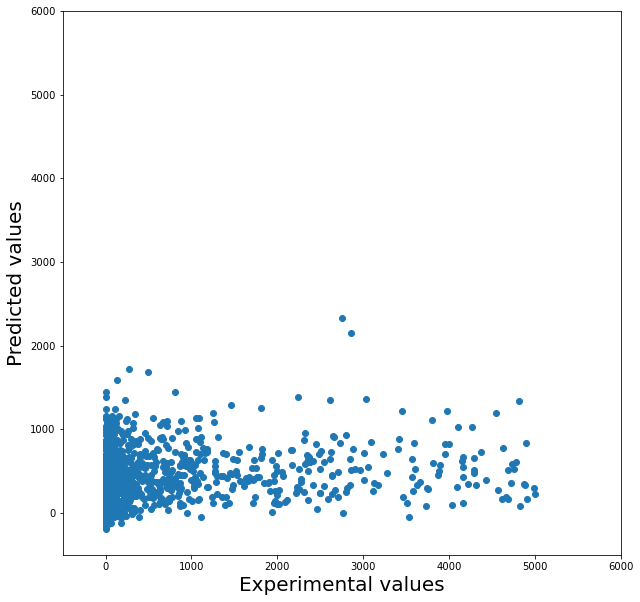

In [252]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(y_test, f_mean.detach().numpy())
ax.set_xlabel('Experimental values', fontsize=20)
ax.set_ylabel('Predicted values', fontsize=20)
ax.set_xlim([-500, 6000])
ax.set_ylim([-500, 6000])
plt.show()